# Классификация русскоязычных новостей по темам
Цель: обучить модель, которая определяет одну из 9 тем по тексту новости.
В этом ноутбуке сравниваются подходы:
- Bag of Words (BoW)
- TF-IDF
- Стемминг vs Лемматизация
- Модель на основе BERT

In [1]:
!pip install transformers==4.41.2 accelerate
!pip install scikit-learn==1.7.0
!pip install nltk==3.9.1
!pip install pymorphy3==2.0.4
!pip install beautifulsoup4==4.9.3
!pip install typing_extensions~=4.14.1
!pip install openpyxl==3.1.5
!pip install selenium==4.34.2
!pip install requests==2.32.4
!pip install torch==2.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

                                                  content  topic
13983   Воробьев проверил модернизацию очистных сооруж...      0
41100   Фонд президентских грантов запустил марафон бл...      0
73582   В российских школах введут программы патриотич...      0
79502   Минобороны отчиталось о наступлении на Херсонс...      0
100017  На Украине начались задержки поездов из-за пер...      3


<Axes: xlabel='topic'>

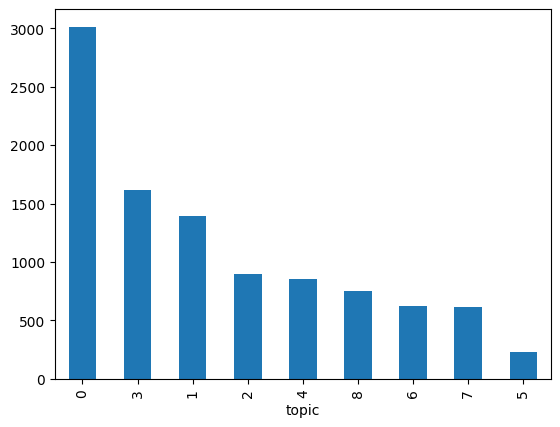

In [3]:
# загрузка и анализ данных
data = pd.read_csv("/kaggle/input/lenta-news/lenta_archive.csv")
data = data.sample(10000, random_state=78)
print(data.head())
data['topic'].value_counts().plot(kind='bar')

In [4]:
X = data['content']
y = data['topic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
# инициализация инструментов для обработки текста
nltk.download('stopwords')
russian_stop_words = stopwords.words('russian')
morph = MorphAnalyzer()
stemmer = SnowballStemmer("russian")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# функция предобработки текста
def preprocess_text(text, lemmatize=True, stem=False):
    """Объединение, очистка и обработка текста"""
    text = str(text).lower()
    text = re.sub(r'[^а-яё\s]', '', text)

    words = text.split()
    words = [word for word in words if word not in russian_stop_words and len(word) > 2]

    if lemmatize:
        words = [morph.parse(word)[0].normal_form for word in words]
    elif stem:
        words = [stemmer.stem(word) for word in words]

    return ' '.join(words)


In [7]:
# обработка текста
X_train_lemm = X_train.apply(preprocess_text, lemmatize=True, stem=False)
X_test_lemm = X_test.apply(preprocess_text, lemmatize=True, stem=False)

X_train_stem = X_train.apply(preprocess_text, lemmatize=False, stem=True)
X_test_stem = X_test.apply(preprocess_text, lemmatize=False, stem=True)

 ## BoW + LogisticRegression + лемматизация

In [8]:
bow = CountVectorizer(max_features=5000)
X_train_bow = bow.fit_transform(X_train_lemm)
X_test_bow = bow.transform(X_test_lemm)

model_bow = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
model_bow.fit(X_train_bow, y_train)
print(classification_report(y_test, model_bow.predict(X_test_bow)))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       736
           1       0.85      0.87      0.86       367
           2       0.89      0.89      0.89       236
           3       0.86      0.88      0.87       394
           4       0.99      0.98      0.98       214
           5       0.82      0.86      0.84        59
           6       0.74      0.65      0.69       165
           7       0.92      0.89      0.91       142
           8       0.87      0.90      0.88       187

    accuracy                           0.87      2500
   macro avg       0.87      0.86      0.86      2500
weighted avg       0.86      0.87      0.86      2500



## BoW + LogisticRegression + стемминг

In [9]:
bow = CountVectorizer(max_features=5000)
X_train_bow = bow.fit_transform(X_train_stem)
X_test_bow = bow.transform(X_test_stem)

model_bow = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
model_bow.fit(X_train_bow, y_train)
print(classification_report(y_test, model_bow.predict(X_test_bow)))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       736
           1       0.85      0.86      0.85       367
           2       0.89      0.90      0.89       236
           3       0.86      0.86      0.86       394
           4       0.99      0.99      0.99       214
           5       0.85      0.86      0.86        59
           6       0.79      0.68      0.73       165
           7       0.93      0.87      0.90       142
           8       0.87      0.90      0.88       187

    accuracy                           0.86      2500
   macro avg       0.87      0.86      0.87      2500
weighted avg       0.86      0.86      0.86      2500



## TF-IDF + LogisticRegression + лемматизация

In [10]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=3)
X_train_tfidf =tfidf.fit_transform(X_train_lemm)
X_test_tfidf = tfidf.transform(X_test_lemm)

model_tfidf = LogisticRegression(C=8.0, solver='lbfgs', max_iter=1000, class_weight='balanced')
model_tfidf.fit(X_train_tfidf, y_train)
print(classification_report(y_test, model_tfidf.predict(X_test_tfidf)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       736
           1       0.87      0.89      0.88       367
           2       0.91      0.90      0.91       236
           3       0.88      0.90      0.89       394
           4       0.99      0.99      0.99       214
           5       0.80      0.88      0.84        59
           6       0.75      0.72      0.73       165
           7       0.92      0.89      0.91       142
           8       0.87      0.92      0.89       187

    accuracy                           0.88      2500
   macro avg       0.87      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



## TF-IDF + LogisticRegression + стемминг

In [11]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=3)
X_train_tfidf = tfidf.fit_transform(X_train_stem)
X_test_tfidf = tfidf.transform(X_test_stem)

model_tfidf = LogisticRegression(C=8.0, solver='lbfgs', max_iter=1000, class_weight='balanced')
model_tfidf.fit(X_train_tfidf, y_train)
print(classification_report(y_test, model_tfidf.predict(X_test_tfidf)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       736
           1       0.86      0.89      0.87       367
           2       0.93      0.89      0.91       236
           3       0.88      0.90      0.89       394
           4       0.99      0.99      0.99       214
           5       0.80      0.86      0.83        59
           6       0.76      0.70      0.73       165
           7       0.91      0.89      0.90       142
           8       0.87      0.93      0.90       187

    accuracy                           0.88      2500
   macro avg       0.87      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



## BERT (RuBERT)

In [12]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загрузка модели и токенизатора
model_name = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

# функция для получения эмбеддингов
def get_embeddings(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Извлечение эмбеддингов"):
        batch = texts[i:i + batch_size]
        encoded = tokenizer(
            batch,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**encoded)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embeddings.cpu().numpy())
            
    return np.vstack(embeddings)

train_embeddings = get_embeddings(X_train.tolist())
test_embeddings = get_embeddings(X_test.tolist())

model_lr = LogisticRegression(
    C=1,
    class_weight='balanced',
    max_iter=1000,
    solver='saga',
    random_state=42
)
model_lr.fit(train_embeddings, y_train)

print(classification_report(y_test, model_lr.predict(test_embeddings)))

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Извлечение эмбеддингов: 100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


              precision    recall  f1-score   support

           0       0.85      0.64      0.73       736
           1       0.80      0.86      0.83       367
           2       0.80      0.85      0.83       236
           3       0.77      0.79      0.78       394
           4       0.96      0.93      0.95       214
           5       0.68      0.81      0.74        59
           6       0.46      0.67      0.55       165
           7       0.75      0.89      0.82       142
           8       0.75      0.85      0.80       187

    accuracy                           0.78      2500
   macro avg       0.76      0.81      0.78      2500
weighted avg       0.79      0.78      0.78      2500



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
